# Style transfer using GANs

* dataset: 17flowers 
* Image A: Pansy flower (image_1281 to image_1360)
* Image B: Tigerlily flower (image_0481 to image_0560)


### Setup

In [1]:
import itertools
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import DataLoader, random_split

from datasets import ImageDataset
from models import Generator, Discriminator


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.__version__)


cuda:0
1.9.0+cu111


In [3]:
DATASET_DIR = Path("./datasets/17flowers")
RESULTS_DIR = Path("./results/17flowers")
CHECKPOINTS_DIR = Path("./checkpoints/17flowers")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
CHECKPOINTS_DIR.mkdir(parents=True, exist_ok=True)

IMG_SIZE = 128
IMG_CHANNELS = 3
TRAIN_TEST_SPLIT = 0.9
BATCH_SIZE = 4
EPOCHS = 100


### Setup training and testing datasets and loaders

In [4]:
transform = transforms.Compose(
    [
        transforms.Resize(IMG_SIZE),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
    ]
)

dataset = ImageDataset(root=DATASET_DIR, transform=transform, unaligned=True)

# ? Split dataset into train and test sets
train_size = int(TRAIN_TEST_SPLIT * len(dataset))
test_size = len(dataset) - train_size
train_dataset, valid_dataset = random_split(dataset, [train_size, test_size])

# ? Create dataset loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)


### Visualize training data

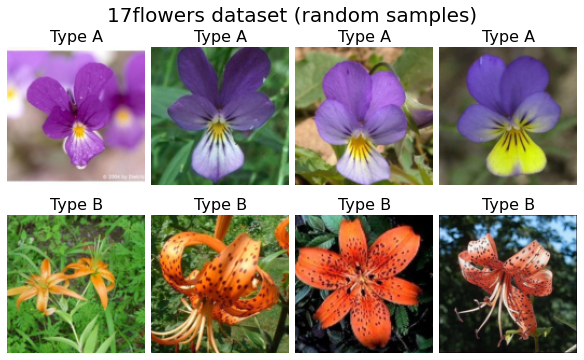

In [5]:
sample_batch = next(iter(train_loader))
fig, axes = plt.subplots(2, BATCH_SIZE, figsize=(2 * BATCH_SIZE, 5), constrained_layout=True)
axes = list(map(list, zip(*axes)))
fig.suptitle("17flowers dataset (random samples)", fontsize=20)

for i, (ax0, ax1) in enumerate(axes):
    ax0.imshow(sample_batch['A'][i].permute(1, 2, 0))
    ax0.axis("off")
    ax0.set_title("Type A", fontsize=16)

    ax1.imshow(sample_batch['B'][i].permute(1, 2, 0))
    ax1.axis("off")
    ax1.set_title("Type B", fontsize=16)

fig.savefig(RESULTS_DIR / "dataset_samples.png", facecolor="w", transparent=False)


### Define models, loss functions and optimizers

In [6]:
netG_A2B = Generator(in_channels=IMG_CHANNELS, out_channels=IMG_CHANNELS).to(device)
netG_B2A = Generator(in_channels=IMG_CHANNELS, out_channels=IMG_CHANNELS).to(device)
print(netG_A2B)

netD_A = Discriminator(in_channels=IMG_CHANNELS).to(device)
netD_B = Discriminator(in_channels=IMG_CHANNELS).to(device)
print(netD_A)

# ? losses
criterion_adversarial = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

# ? optimizers (for both G and D)
optimizerG = optim.Adam(
    itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()),
    lr=0.0002,
    betas=(0.5, 0.999)
)

optimizerD_A = optim.Adam(netD_A.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizerD_B = optim.Adam(netD_B.parameters(), lr=0.0001, betas=(0.5, 0.999))


Generator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (8): ReLU(inplace=True)
    (9): ResidualBlock(
      (conv_block): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): InstanceN

### Train the models

In [10]:
def visualize_results(title, netG_A2B, netG_B2A, sample_A, sample_B, save_file, close=False):
    fig, axes = plt.subplots(BATCH_SIZE, 6, figsize=(10, BATCH_SIZE * 2), constrained_layout=True)
    [ax.set_axis_off() for ax in axes.ravel()]
    fig.suptitle(title, fontsize=20)

    with torch.no_grad():
        fake_B = netG_A2B(sample_A).detach()
        recon_A = netG_B2A(fake_B).detach()
        fake_A = netG_B2A(sample_B).detach()
        recon_B = netG_A2B(fake_A).detach()

    sample_A = sample_A.cpu().clamp(0, 1).permute(0, 2, 3, 1)
    sample_B = sample_B.cpu().clamp(0, 1).permute(0, 2, 3, 1)
    fake_A = fake_A.cpu().clamp(0, 1).permute(0, 2, 3, 1)
    fake_B = fake_B.cpu().clamp(0, 1).permute(0, 2, 3, 1)
    recon_A = recon_A.cpu().clamp(0, 1).permute(0, 2, 3, 1)
    recon_B = recon_B.cpu().clamp(0, 1).permute(0, 2, 3, 1)

    for i, ax in enumerate(axes):
        ax[0].imshow(sample_A[i])
        ax[0].set_title("A")
        ax[1].imshow(fake_B[i])
        ax[1].set_title("A -> B")
        ax[2].imshow(recon_A[i])
        ax[2].set_title("A -> B -> A")

        ax[3].imshow(sample_B[i])
        ax[3].set_title("B")
        ax[4].imshow(fake_A[i])
        ax[4].set_title("B -> A")
        ax[5].imshow(recon_B[i])
        ax[5].set_title("B -> A -> B")

    fig.savefig(RESULTS_DIR / save_file, facecolor="w", dpi=300)

    if close:
        plt.close()


#### Training pipeline

In [12]:
# ? batch of latent vectors to visualize the progression of the generator
noise_A = torch.randn(BATCH_SIZE, IMG_CHANNELS, IMG_SIZE, IMG_SIZE, device=device)
noise_B = torch.randn(BATCH_SIZE, IMG_CHANNELS, IMG_SIZE, IMG_SIZE, device=device)


In [8]:
target_real = torch.ones(BATCH_SIZE, device=device)
target_fake = torch.zeros(BATCH_SIZE, device=device)

epoch_losses_G = []
epoch_losses_D_A = []
epoch_losses_D_B = []

print("Starting training loop...")
for epoch in range(1, EPOCHS + 1):
    epoch_loss_G = 0
    epoch_loss_D_A = 0
    epoch_loss_D_B = 0

    for i, batch in enumerate(train_loader):
        real_A, real_B = batch["A"].to(device), batch["B"].to(device)

        # **** Generator A2B & B2A *** #
        optimizerG.zero_grad()

        # ? GAN loss
        fake_B = netG_A2B(real_A)
        pred_fake = netD_B(fake_B)
        loss_GAN_A2B = criterion_adversarial(pred_fake, target_real)

        fake_A = netG_B2A(real_B)
        pred_fake = netD_A(fake_A)
        loss_GAN_B2A = criterion_adversarial(pred_fake, target_real)

        # ? Identity loss
        # ? netG_B2A(A) should equal A if real A is fed
        # ? netG_A2B(B) should equal B if real B is fed
        same_A = netG_B2A(real_A)
        loss_identity_A = criterion_identity(same_A, real_A) * 5.0

        same_B = netG_A2B(real_B)
        loss_identity_B = criterion_identity(same_B, real_B) * 5.0

        # ? Cycle loss
        recon_A = netG_B2A(fake_B)
        loss_cycle_ABA = criterion_cycle(recon_A, real_A) * 10.0

        recon_B = netG_A2B(fake_A)
        loss_cycle_BAB = criterion_cycle(recon_B, real_B) * 10.0

        loss_G = (
            loss_identity_A
            + loss_identity_B
            + loss_GAN_A2B
            + loss_GAN_B2A
            + loss_cycle_ABA
            + loss_cycle_BAB
        )

        # ? Calculate gradients for netG_A2B and netG_B2A
        loss_G.backward()
        # ? Update the weights of netG_A2B and netG_B2A
        optimizerG.step()
        # **************************** #

        # ****** Discriminator A ***** #
        optimizerD_A.zero_grad()

        # ? Real loss
        pred_real = netD_A(real_A)
        loss_D_real = criterion_adversarial(pred_real, target_real)

        # ? Fake loss
        pred_fake = netD_A(fake_A.detach())
        loss_D_fake = criterion_adversarial(pred_fake, target_fake)

        # ? Total loss
        loss_D_A = (loss_D_real + loss_D_fake) * 0.5

        loss_D_A.backward()
        optimizerD_A.step()
        # *****************************#

        # ****** Discriminator B ******#
        optimizerD_B.zero_grad()

        # ? Real loss
        pred_real = netD_B(real_B)
        loss_D_real = criterion_adversarial(pred_real, target_real)

        # Fake loss
        pred_fake = netD_B(fake_B.detach())
        loss_D_fake = criterion_adversarial(pred_fake, target_fake)

        # Total loss
        loss_D_B = (loss_D_real + loss_D_fake) * 0.5

        loss_D_B.backward()
        optimizerD_B.step()
        # *****************************#

        epoch_loss_G += loss_G.item()
        epoch_loss_D_A += loss_D_A.item()
        epoch_loss_D_B += loss_D_B.item()

    epoch_loss_G /= len(train_dataset)
    epoch_loss_D_A /= len(train_dataset)
    epoch_loss_D_B /= len(train_dataset)

    epoch_losses_G.append(epoch_loss_G)
    epoch_losses_D_A.append(epoch_loss_D_A)
    epoch_losses_D_B.append(epoch_loss_D_B)

    # ? Output training stats
    print(
        f"[Epoch {epoch}/{EPOCHS}]\tLoss G: {epoch_loss_D_B:.4f}\t"
        f"Loss D_A: {epoch_loss_G:.4f}\tLoss D_B: {epoch_loss_D_A:.4f}"
    )

    if epoch % 10 == 0:
        # ? Output for image as input
        visualize_results(
            title="CycleGAN Style Transfer Results\nA: Pansy, B: Tigerlily",
            netG_A2B=netG_A2B,
            netG_B2A=netG_B2A,
            sample_A=real_A,
            sample_B=real_B,
            save_file=f"training/image_input_cycle_epoch_{epoch}.png",
            close=True,
        )

        # ? Output for noise as input
        visualize_results(
            title="CycleGAN Style Transfer Results on Noise Input\nA: Pansy, B: Tigerlily",
            netG_A2B=netG_A2B,
            netG_B2A=netG_B2A,
            sample_A=noise_A,
            sample_B=noise_B,
            save_file=f"training/noise_input_cycle_epoch_{epoch}.png",
            close=True,
        )


torch.save(netG_A2B.state_dict(), CHECKPOINTS_DIR / "netG_A2B_final.pth")
torch.save(netG_B2A.state_dict(), CHECKPOINTS_DIR / "netG_B2A_final.pth")
torch.save(netD_A.state_dict(), CHECKPOINTS_DIR / "netD_A_final.pth")
torch.save(netD_B.state_dict(), CHECKPOINTS_DIR / "netD_B_final.pth")


Starting training loop...
[Epoch 1/100]	Loss G: 0.0616	Loss D_A: 1.7314	Loss D_B: 0.0552
[Epoch 2/100]	Loss G: 0.0552	Loss D_A: 1.3953	Loss D_B: 0.0535
[Epoch 3/100]	Loss G: 0.0548	Loss D_A: 1.3320	Loss D_B: 0.0562
[Epoch 4/100]	Loss G: 0.0578	Loss D_A: 1.3100	Loss D_B: 0.0560
[Epoch 5/100]	Loss G: 0.0531	Loss D_A: 1.3183	Loss D_B: 0.0544
[Epoch 6/100]	Loss G: 0.0546	Loss D_A: 1.2148	Loss D_B: 0.0531
[Epoch 7/100]	Loss G: 0.0530	Loss D_A: 1.2278	Loss D_B: 0.0549
[Epoch 8/100]	Loss G: 0.0501	Loss D_A: 1.1886	Loss D_B: 0.0477
[Epoch 9/100]	Loss G: 0.0501	Loss D_A: 1.2027	Loss D_B: 0.0499
[Epoch 10/100]	Loss G: 0.0490	Loss D_A: 1.2178	Loss D_B: 0.0470
[Epoch 11/100]	Loss G: 0.0500	Loss D_A: 1.1576	Loss D_B: 0.0463
[Epoch 12/100]	Loss G: 0.0444	Loss D_A: 1.1412	Loss D_B: 0.0448
[Epoch 13/100]	Loss G: 0.0445	Loss D_A: 1.1641	Loss D_B: 0.0428
[Epoch 14/100]	Loss G: 0.0461	Loss D_A: 1.1273	Loss D_B: 0.0399
[Epoch 15/100]	Loss G: 0.0440	Loss D_A: 1.1318	Loss D_B: 0.0493
[Epoch 16/100]	Loss G: 

### Visualize results

#### Loss plots

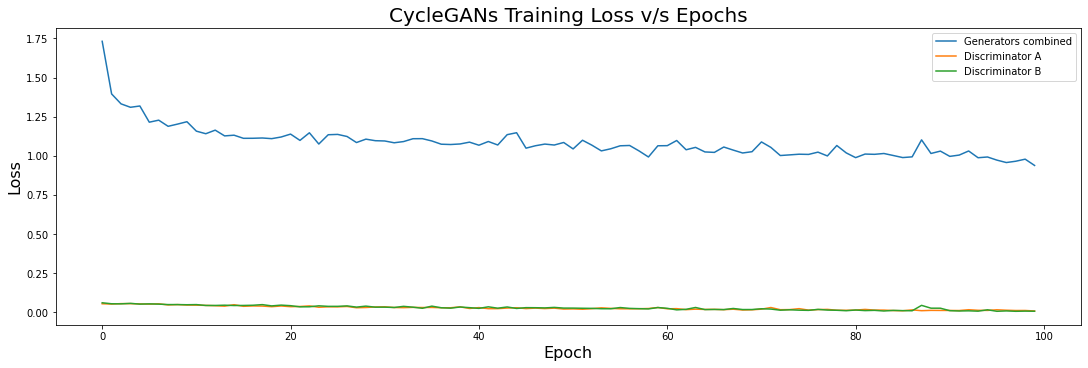

In [9]:
plt.figure(figsize=(15, 5), constrained_layout=True)
plt.title("CycleGANs Training Loss v/s Epochs", fontsize=20)
plt.plot(epoch_losses_G, label="Generators combined")
plt.plot(epoch_losses_D_A, label="Discriminator A")
plt.plot(epoch_losses_D_B, label="Discriminator B")
plt.legend()
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.savefig(RESULTS_DIR / "train_loss.png", facecolor="w", transparent=False)


### Test results

In [8]:
netG_A2B = Generator(in_channels=IMG_CHANNELS, out_channels=IMG_CHANNELS).to(device)
netG_A2B.load_state_dict(torch.load(CHECKPOINTS_DIR / "netG_A2B_final.pth"))

netG_B2A = Generator(in_channels=IMG_CHANNELS, out_channels=IMG_CHANNELS).to(device)
netG_B2A.load_state_dict(torch.load(CHECKPOINTS_DIR / "netG_B2A_final.pth"))

netD_A = Discriminator(in_channels=IMG_CHANNELS).to(device)
netD_A.load_state_dict(torch.load(CHECKPOINTS_DIR / "netD_A_final.pth"))

netD_B = Discriminator(in_channels=IMG_CHANNELS).to(device)
netD_B.load_state_dict(torch.load(CHECKPOINTS_DIR / "netD_B_final.pth"))


<All keys matched successfully>

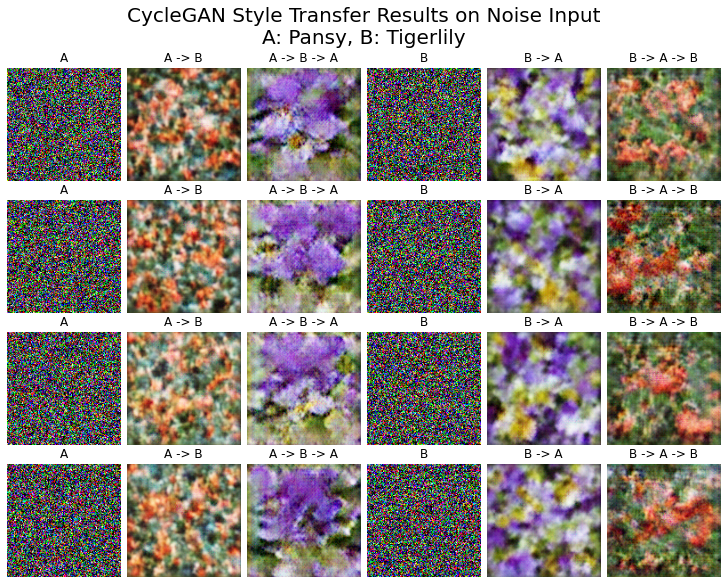

In [13]:
# ? Output for image as input
visualize_results(
    title="CycleGAN Style Transfer Results\nA: Pansy, B: Tigerlily",
    netG_A2B=netG_A2B,
    netG_B2A=netG_B2A,
    sample_A=sample_batch["A"].to(device),
    sample_B=sample_batch["B"].to(device),
    save_file="image_input_cycle.png",
)

# ? Output for noise as input
visualize_results(
    title="CycleGAN Style Transfer Results on Noise Input\nA: Pansy, B: Tigerlily",
    netG_A2B=netG_A2B,
    netG_B2A=netG_B2A,
    sample_A=noise_A,
    sample_B=noise_B,
    save_file="noise_input_cycle.png",
)


#### Results vs Epochs

In [ ]:
# import torchvision.utils as vutils
# from IPython.display import HTML
# from matplotlib import animation

# fig = plt.figure(figsize=(8,8))
# plt.axis("off")

# ims = np.array(np.transpose(i, (1, 2, 0)) for i in img_list_A)
# ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in img_list_A]
# ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

# HTML(ani.to_jshtml())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

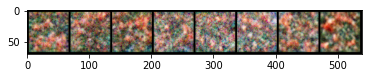

In [ ]:
# fig = plt.figure(figsize=(8,8))
# plt.axis("off")

# ims = np.array(np.transpose(i, (1, 2, 0)) for i in img_list_B)
# ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in img_list_B]
# ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

# HTML(ani.to_jshtml())
